In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import sem
import os
import scipy
from scipy.integrate import odeint
import scipy.integrate as integ

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#053061', '#f4a582']

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
    return fig_dims


## Auxotroph communities
![schematic](schematic.png)


## Invasion experiments (example 1: species $\alpha$, $\beta$, and $\gamma$)

In [2]:
NumOfAminoAcids = 3
NumOfSpecies = 500

B0 = np.ones(NumOfSpecies)
R0 = np.zeros(NumOfAminoAcids+1); R0[0] = 1
R_pool = np.zeros(NumOfAminoAcids+1); R_pool[0] = 10
B = B0.copy()
R = R0.copy()

distribution_of_enzymes_array = np.ones((NumOfSpecies, NumOfAminoAcids+1)) # the first one is the transformation of the primary resource
cost_array = np.ones((NumOfSpecies, NumOfAminoAcids+1))  # the first one is the transformation of the primary resource
production_ratio_array = np.ones((NumOfSpecies, NumOfAminoAcids))
production_ratio_array = np.random.uniform(low=0.1, high=1.0, size=(NumOfSpecies, NumOfAminoAcids))
production_ratio_array = production_ratio_array / np.sum(production_ratio_array, 1)[:, np.newaxis]
production_ratio_array[:3, :] = np.array([[0.42,0.16,0.42],[0.45,0.40,0.15],[0.16,0.46,0.38]])
stoichiometry_array = np.ones((NumOfSpecies, NumOfAminoAcids))
stoichiometry_array = stoichiometry_array / np.sum(stoichiometry_array, 1)[:, np.newaxis]


In [3]:
dt = 0.1
D = 0.2
t_sim = 50000
B = B0.copy()
R = R0.copy()
B_t = np.zeros((t_sim+1, B.shape[0]))
R_t = np.zeros((t_sim+1, R.shape[0]))
B_t[0] = B; R_t[0] = R;

def dydt(t, y):
    dydt = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
    B = y[:NumOfSpecies]
    R = y[NumOfSpecies:]

    growth_rate_all = np.zeros(NumOfSpecies)
    consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))

    converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
    uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]

    limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
    consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
    growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
    consumption_fluxes[:,0] = converted_fluxes.sum(1)
    uptake_fluxes[:,0] = consumption_fluxes[:,0]

    production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

    dBdt = B * growth_rate_all - D * B
    dRdt = - np.dot(B, (uptake_fluxes)) - D * R + D * R_pool
    dRdt[1:] = dRdt[1:] + np.dot(B, (production_fluxes))

    dydt[:NumOfSpecies] = dBdt
    dydt[NumOfSpecies:] = dRdt

    return dydt

y0 = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
y0[:NumOfSpecies] = B_t[0]
y0[NumOfSpecies:] = R_t[0]

t_min=0
t_max=5e4
solution=integ.LSODA(dydt,t_min,y0,t_max)
solution=integ.solve_ivp(dydt,[t_min, t_max],y0,method='LSODA', atol=1e-4, rtol=1e-6)
ts = solution.t
Ps = solution.y.transpose()

B_t = Ps[:,:NumOfSpecies]
R_t = Ps[:,NumOfSpecies:]

y = Ps[-1, :]
B = y[:NumOfSpecies]
R = y[NumOfSpecies:]

growth_rate_all = np.zeros(NumOfSpecies)
consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))
converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]
limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
consumption_fluxes[:,0] = converted_fluxes.sum(1)
uptake_fluxes[:,0] = consumption_fluxes[:,0]
production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

[0 1 2]


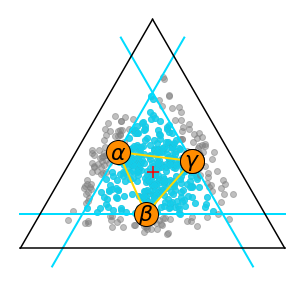

In [4]:
from itertools import combinations
combs = [[0,1,2]]
species_annotations = ["$\\alpha$", "$\\beta$", "$\\gamma$"]
for comb in combs:
    print(np.array(comb))
    i_subset = np.array(comb)                

    dt = 0.1
    D = 0.2
    t_sim = 50000
    B = B0.copy()
    R = R0.copy()
    B[:] = 0; B[i_subset] = B0[i_subset];
    B_t = np.zeros((t_sim+1, B.shape[0]))
    R_t = np.zeros((t_sim+1, R.shape[0]))
    B_t[0] = B; R_t[0] = R;

    def dydt(y, t):
        dydt = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
        B = y[:NumOfSpecies]
        R = y[NumOfSpecies:]

        growth_rate_all = np.zeros(NumOfSpecies)
        consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
        uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
        production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))

        converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
        uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]

        limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
        consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
        growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
        consumption_fluxes[:,0] = converted_fluxes.sum(1)
        uptake_fluxes[:,0] = consumption_fluxes[:,0]

        production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

        dBdt = B * growth_rate_all - D * B
        dRdt = - np.dot(B, (uptake_fluxes)) - D * R + D * R_pool
        dRdt[1:] = dRdt[1:] + np.dot(B, (production_fluxes))

        dydt[:NumOfSpecies] = dBdt
        dydt[NumOfSpecies:] = dRdt

        return dydt

    y0 = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
    y0[:NumOfSpecies] = B_t[0]
    y0[NumOfSpecies:] = R_t[0]
    scipy.integrate.ode(dydt).set_integrator('vode', method='bdf', order=5, rtol=1e-5, atol=1e-7)
    ts = np.linspace(0, 100, 4000)
    Ps = odeint(dydt, y0, ts)

    B_t = Ps[:,:NumOfSpecies]
    R_t = Ps[:,NumOfSpecies:]

    y = Ps[-1, :]
    B = y[:NumOfSpecies]
    R = y[NumOfSpecies:]

    growth_rate_all = np.zeros(NumOfSpecies)
    consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))
    converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
    uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]
    limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
    consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
    growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
    consumption_fluxes[:,0] = converted_fluxes.sum(1)
    uptake_fluxes[:,0] = consumption_fluxes[:,0]
    production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]
    
    i_survivors = np.intersect1d(np.where(growth_rate_all > D*0.99)[0], np.where(B > 0.001)[0])
    fig_dims = figure_size_setting(600)
    fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

    invade_index = 0
    for i in range(NumOfSpecies):
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', alpha=0.5)
        if i == range(NumOfSpecies)[-1]:
            axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', label='species cannot invade')
        #### invadable region
        if (growth_rate_all[i] > D) & (B_t[-1,i] < 1e-3):
            if (invade_index == 0):
                axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='#00dcff', alpha=0.7, label='species can invade'); invade_index = 1
            else:
                axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='#00dcff', alpha=0.7)
    #### ZNGI region
    [x,y,z] = production_ratio_array[0,:]; [x1,y1] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    [x,y,z] = production_ratio_array[1,:]; [x2,y2] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    [x,y,z] = production_ratio_array[2,:]; [x3,y3] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    shift1 = y2
    shift2 = (np.sqrt(3)/2-y3) / (np.sqrt(3)/2) * 0.5 - x3
    shift3 = (np.sqrt(3)/2-y1) / (np.sqrt(3)/2) * 0.5 + x1
    axes.plot([-0.5,0.5],[0+shift1,0+shift1],'-', color='#00dcff', lw=2)
    axes.plot([0.5+0.04-shift2,0+0.04-shift2],[0-np.sqrt(3)*0.04,np.sqrt(3)/2-np.sqrt(3)*0.04],'-', color='#00dcff', lw=2)
    axes.plot([0+shift3-0.04,-0.5-0.04+shift3],[np.sqrt(3)/2-np.sqrt(3)*0.04,0-np.sqrt(3)*0.04],'-', color='#00dcff', lw=2)

    #### feasibility region
    for i_species1, i_species2 in zip([0,0,1],[1,2,2]):
        [x1,y1,z1] = production_ratio_array[i_species1,:]
        [x2,y2,z2] = production_ratio_array[i_species2,:]
        axes.plot([0.5-x1-0.5*z1, 0.5-x2-0.5*z2], [np.sqrt(3)/2*z1, np.sqrt(3)/2*z2], '-', color='gold', lw=2) 

    #### species that survived and did not survive
    i_extinct = np.array(list(set(i_subset) - set(i_survivors)))
    for i in i_extinct:
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', markersize=18, markeredgecolor='k')
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'x', color='red', markersize=20, markeredgewidth=1)
        # loop through each x,y pair
        axes.annotate(str(i+4),  xy=(0.5-x-0.5*z, np.sqrt(3)/2*z-0.005), color='black', fontsize="large", 
                    weight='heavy', horizontalalignment='center', verticalalignment='center')
        if i == i_extinct[-1]:
            grey_circle, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', markersize=18, markeredgecolor='k', label='extinct species')
            red_cross, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'x', color='red', markersize=20, markeredgewidth=2, label='extinct species')
    for i in i_survivors:
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='darkorange', markersize=24, markeredgecolor='k')
        # loop through each x,y pair
        axes.annotate(species_annotations[i],  xy=(0.5-x-0.5*z, np.sqrt(3)/2*z-0.005), color='black', fontsize=22, 
                    weight='heavy', horizontalalignment='center', verticalalignment='center')
        if i == i_survivors[-1]:
            axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='darkorange', markersize=24, markeredgecolor='k', label='survivors')

    axes.plot(0, 1/3*np.sqrt(3)/2, 'r+', markersize=12, markeredgewidth=1.5, label='stoichiometry vector') 
    community_vector = np.sum(production_ratio_array[i_survivors] * B[i_survivors][:,np.newaxis], 0)
    community_vector = community_vector / np.sum(community_vector)
    [x,y,z] = community_vector
    axes.plot([-0.5,0.5],[0,0],'k-')
    axes.plot([0.5,0],[0,np.sqrt(3)/2],'k-')
    axes.plot([0,-0.5],[np.sqrt(3)/2,0],'k-')
    axes.set_aspect(aspect='equal')
    axes.set_axis_off()

    fig.subplots_adjust(left=.0, bottom=.05, right=1.0, top=.97, hspace=0.1)
    #fig.savefig('./figures/Fig2b.pdf', dpi=300)


## Invasion experiments (example 2: species $\delta$, $\epsilon$, $\zeta$)

In [5]:
NumOfAminoAcids = 3
NumOfSpecies = 500

B0 = np.ones(NumOfSpecies)
R0 = np.zeros(NumOfAminoAcids+1); R0[0] = 1
R_pool = np.zeros(NumOfAminoAcids+1); R_pool[0] = 10
B = B0.copy()
R = R0.copy()

distribution_of_enzymes_array = np.ones((NumOfSpecies, NumOfAminoAcids+1)) # the first one is the transformation of the primary resource
cost_array = np.ones((NumOfSpecies, NumOfAminoAcids+1))  # the first one is the transformation of the primary resource
production_ratio_array = np.ones((NumOfSpecies, NumOfAminoAcids))
production_ratio_array = np.random.uniform(low=0.1, high=1.0, size=(NumOfSpecies, NumOfAminoAcids))
production_ratio_array = production_ratio_array / np.sum(production_ratio_array, 1)[:, np.newaxis]
production_ratio_array[:3, :] = np.array([[0.26,0.14,0.6],[0.33,0.52,0.15],[0.1,0.6,0.3]])
stoichiometry_array = np.ones((NumOfSpecies, NumOfAminoAcids))
stoichiometry_array = stoichiometry_array / np.sum(stoichiometry_array, 1)[:, np.newaxis]


In [6]:
dt = 0.1
D = 0.2
t_sim = 50000
B = B0.copy()
R = R0.copy()
B_t = np.zeros((t_sim+1, B.shape[0]))
R_t = np.zeros((t_sim+1, R.shape[0]))
B_t[0] = B; R_t[0] = R;

def dydt(t, y):
    dydt = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
    B = y[:NumOfSpecies]
    R = y[NumOfSpecies:]

    growth_rate_all = np.zeros(NumOfSpecies)
    consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))

    converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
    uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]

    limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
    consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
    growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
    consumption_fluxes[:,0] = converted_fluxes.sum(1)
    uptake_fluxes[:,0] = consumption_fluxes[:,0]

    production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

    dBdt = B * growth_rate_all - D * B
    dRdt = - np.dot(B, (uptake_fluxes)) - D * R + D * R_pool
    dRdt[1:] = dRdt[1:] + np.dot(B, (production_fluxes))

    dydt[:NumOfSpecies] = dBdt
    dydt[NumOfSpecies:] = dRdt

    return dydt

y0 = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
y0[:NumOfSpecies] = B_t[0]
y0[NumOfSpecies:] = R_t[0]

t_min=0
t_max=5e4
solution=integ.LSODA(dydt,t_min,y0,t_max)
solution=integ.solve_ivp(dydt,[t_min, t_max],y0,method='LSODA', atol=1e-4, rtol=1e-6)
ts = solution.t
Ps = solution.y.transpose()

B_t = Ps[:,:NumOfSpecies]
R_t = Ps[:,NumOfSpecies:]

y = Ps[-1, :]
B = y[:NumOfSpecies]
R = y[NumOfSpecies:]

growth_rate_all = np.zeros(NumOfSpecies)
consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))
converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]
limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
consumption_fluxes[:,0] = converted_fluxes.sum(1)
uptake_fluxes[:,0] = consumption_fluxes[:,0]
production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

[0 1 2]


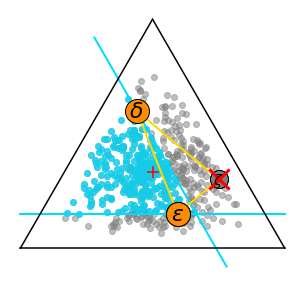

In [7]:
from itertools import combinations
combs = [[0,1,2]]
species_annotations = ["$\\delta$", "$\\epsilon$", "$\\zeta$"]
for comb in combs:
    print(np.array(comb))
    i_subset = np.array(comb)                

    dt = 0.1
    D = 0.2
    t_sim = 50000
    B = B0.copy()
    R = R0.copy()
    B[:] = 0; B[i_subset] = B0[i_subset];
    B_t = np.zeros((t_sim+1, B.shape[0]))
    R_t = np.zeros((t_sim+1, R.shape[0]))
    B_t[0] = B; R_t[0] = R;

    def dydt(y, t):
        dydt = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
        B = y[:NumOfSpecies]
        R = y[NumOfSpecies:]

        growth_rate_all = np.zeros(NumOfSpecies)
        consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
        uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
        production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))

        converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
        uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]

        limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
        consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
        growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
        consumption_fluxes[:,0] = converted_fluxes.sum(1)
        uptake_fluxes[:,0] = consumption_fluxes[:,0]

        production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

        dBdt = B * growth_rate_all - D * B
        dRdt = - np.dot(B, (uptake_fluxes)) - D * R + D * R_pool
        dRdt[1:] = dRdt[1:] + np.dot(B, (production_fluxes))

        dydt[:NumOfSpecies] = dBdt
        dydt[NumOfSpecies:] = dRdt

        return dydt

    y0 = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
    y0[:NumOfSpecies] = B_t[0]
    y0[NumOfSpecies:] = R_t[0]
    scipy.integrate.ode(dydt).set_integrator('vode', method='bdf', order=5, rtol=1e-5, atol=1e-7)
    ts = np.linspace(0, 100, 4000)
    Ps = odeint(dydt, y0, ts)

    B_t = Ps[:,:NumOfSpecies]
    R_t = Ps[:,NumOfSpecies:]

    y = Ps[-1, :]
    B = y[:NumOfSpecies]
    R = y[NumOfSpecies:]

    growth_rate_all = np.zeros(NumOfSpecies)
    consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))
    converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
    uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]
    limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
    consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
    growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
    consumption_fluxes[:,0] = converted_fluxes.sum(1)
    uptake_fluxes[:,0] = consumption_fluxes[:,0]
    production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]
    
    i_survivors = np.intersect1d(np.where(growth_rate_all > D*0.999)[0], np.where(B > 0.001)[0])
    fig_dims = figure_size_setting(600)
    fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

    invade_index = 0
    for i in range(NumOfSpecies):
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', alpha=0.5)
        if i == range(NumOfSpecies)[-1]:
            axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', label='species cannot invade')
        #### invadable region
        if (growth_rate_all[i] > D) & (B_t[-1,i] < 1e-3):
            if (invade_index == 0):
                axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='#00dcff', alpha=0.7, label='species can invade'); invade_index = 1
            else:
                axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='#00dcff', alpha=0.7)
                
    #### ZNGI region
    [x,y,z] = production_ratio_array[0,:]; [x1,y1] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    [x,y,z] = production_ratio_array[1,:]; [x2,y2] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    [x,y,z] = production_ratio_array[2,:]; [x3,y3] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    shift1 = y2
    shift2 = (np.sqrt(3)/2-y1) / (np.sqrt(3)/2) * 0.5 - x1
    axes.plot([-0.5,0.5],[0+shift1,0+shift1],'-', color='#00dcff', lw=2)
    axes.plot([0.5+0.04-shift2,0+0.04-shift2],[0-np.sqrt(3)*0.04,np.sqrt(3)/2-np.sqrt(3)*0.04],'-', color='#00dcff', lw=2)

    #### feasibility region
    for i_species1, i_species2 in zip([0,0,1],[1,2,2]):
        [x1,y1,z1] = production_ratio_array[i_species1,:]
        [x2,y2,z2] = production_ratio_array[i_species2,:]
        axes.plot([0.5-x1-0.5*z1, 0.5-x2-0.5*z2], [np.sqrt(3)/2*z1, np.sqrt(3)/2*z2], '-', color='gold', lw=2) 

    #### species that survived and did not survive
    i_extinct = np.array(list(set(i_subset) - set(i_survivors)))
    for i in i_extinct:
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', markersize=18, markeredgecolor='k')
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'x', color='red', markersize=20, markeredgewidth=1)
        # loop through each x,y pair
        axes.annotate(species_annotations[i],  xy=(0.5-x-0.5*z, np.sqrt(3)/2*z-0.005), color='black', fontsize="large", 
                    weight='heavy', horizontalalignment='center', verticalalignment='center')
        if i == i_extinct[-1]:
            grey_circle, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', markersize=18, markeredgecolor='k', label='extinct species')
            red_cross, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'x', color='red', markersize=20, markeredgewidth=3, label='extinct species')
    for i in i_survivors:
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='darkorange', markersize=24, markeredgecolor='k')
        # loop through each x,y pair
        axes.annotate(species_annotations[i],  xy=(0.5-x-0.5*z, np.sqrt(3)/2*z-0.005), color='black', fontsize=22, 
                    weight='heavy', horizontalalignment='center', verticalalignment='center')
        if i == i_survivors[-1]:
            axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='darkorange', markersize=24, markeredgecolor='k', label='survivors')
    axes.plot(0, 1/3*np.sqrt(3)/2, 'r+', markersize=12, markeredgewidth=1.5, label='stoichiometry vector') 
    community_vector = np.sum(production_ratio_array[i_survivors] * B[i_survivors][:,np.newaxis], 0)
    community_vector = community_vector / np.sum(community_vector)
    [x,y,z] = community_vector
    axes.plot([-0.5,0.5],[0,0],'k-')
    axes.plot([0.5,0],[0,np.sqrt(3)/2],'k-')
    axes.plot([0,-0.5],[np.sqrt(3)/2,0],'k-')
    axes.set_aspect(aspect='equal')
    axes.set_axis_off()

    fig.subplots_adjust(left=.0, bottom=.05, right=1.0, top=.97, hspace=0.1)
    #fig.savefig('./figures/Fig2c.pdf', dpi=300)


## Invasion experiments (example 3: species $\eta$, $\theta$, $\iota$)

In [8]:
NumOfAminoAcids = 3
NumOfSpecies = 500

B0 = np.ones(NumOfSpecies)
R0 = np.zeros(NumOfAminoAcids+1); R0[0] = 1
R_pool = np.zeros(NumOfAminoAcids+1); R_pool[0] = 10
B = B0.copy()
R = R0.copy()

distribution_of_enzymes_array = np.ones((NumOfSpecies, NumOfAminoAcids+1)) # the first one is the transformation of the primary resource
cost_array = np.ones((NumOfSpecies, NumOfAminoAcids+1))  # the first one is the transformation of the primary resource
production_ratio_array = np.ones((NumOfSpecies, NumOfAminoAcids))
production_ratio_array = np.random.uniform(low=0.1, high=1.0, size=(NumOfSpecies, NumOfAminoAcids))
production_ratio_array = production_ratio_array / np.sum(production_ratio_array, 1)[:, np.newaxis]
production_ratio_array[:3, :] = np.array([[0.62,0.16,0.22],[0.25,0.6,0.15],[0.3,0.26,0.44]])
stoichiometry_array = np.ones((NumOfSpecies, NumOfAminoAcids))
stoichiometry_array = stoichiometry_array / np.sum(stoichiometry_array, 1)[:, np.newaxis]


In [9]:
dt = 0.1
D = 0.2
t_sim = 50000
B = B0.copy()
R = R0.copy()
B_t = np.zeros((t_sim+1, B.shape[0]))
R_t = np.zeros((t_sim+1, R.shape[0]))
B_t[0] = B; R_t[0] = R;

def dydt(t, y):
    dydt = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
    B = y[:NumOfSpecies]
    R = y[NumOfSpecies:]

    growth_rate_all = np.zeros(NumOfSpecies)
    consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))

    converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
    uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]

    limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
    consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
    growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
    consumption_fluxes[:,0] = converted_fluxes.sum(1)
    uptake_fluxes[:,0] = consumption_fluxes[:,0]

    production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

    dBdt = B * growth_rate_all - D * B
    dRdt = - np.dot(B, (uptake_fluxes)) - D * R + D * R_pool
    dRdt[1:] = dRdt[1:] + np.dot(B, (production_fluxes))

    dydt[:NumOfSpecies] = dBdt
    dydt[NumOfSpecies:] = dRdt

    return dydt

y0 = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
y0[:NumOfSpecies] = B_t[0]
y0[NumOfSpecies:] = R_t[0]

t_min=0
t_max=5e4
solution=integ.LSODA(dydt,t_min,y0,t_max)
solution=integ.solve_ivp(dydt,[t_min, t_max],y0,method='LSODA', atol=1e-4, rtol=1e-6)
ts = solution.t
Ps = solution.y.transpose()

B_t = Ps[:,:NumOfSpecies]
R_t = Ps[:,NumOfSpecies:]

y = Ps[-1, :]
B = y[:NumOfSpecies]
R = y[NumOfSpecies:]

growth_rate_all = np.zeros(NumOfSpecies)
consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))
converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]
limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
consumption_fluxes[:,0] = converted_fluxes.sum(1)
uptake_fluxes[:,0] = consumption_fluxes[:,0]
production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

[0 1 2]


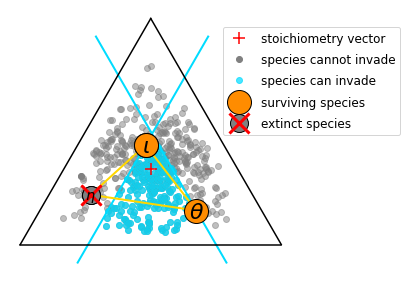

In [10]:
from itertools import combinations
combs = [[0,1,2]]
species_annotations = ["$\\eta$", "$\\theta$", "$\\iota$"]
for comb in combs:
    print(np.array(comb))
    i_subset = np.array(comb)                

    dt = 0.1
    D = 0.2
    t_sim = 50000
    B = B0.copy()
    R = R0.copy()
    B[:] = 0; B[i_subset] = B0[i_subset];
    B_t = np.zeros((t_sim+1, B.shape[0]))
    R_t = np.zeros((t_sim+1, R.shape[0]))
    B_t[0] = B; R_t[0] = R;

    def dydt(y, t):
        dydt = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
        B = y[:NumOfSpecies]
        R = y[NumOfSpecies:]

        growth_rate_all = np.zeros(NumOfSpecies)
        consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
        uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
        production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))

        converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
        uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]

        limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
        consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
        growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
        consumption_fluxes[:,0] = converted_fluxes.sum(1)
        uptake_fluxes[:,0] = consumption_fluxes[:,0]

        production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

        dBdt = B * growth_rate_all - D * B
        dRdt = - np.dot(B, (uptake_fluxes)) - D * R + D * R_pool
        dRdt[1:] = dRdt[1:] + np.dot(B, (production_fluxes))

        dydt[:NumOfSpecies] = dBdt
        dydt[NumOfSpecies:] = dRdt

        return dydt

    y0 = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
    y0[:NumOfSpecies] = B_t[0]
    y0[NumOfSpecies:] = R_t[0]
    scipy.integrate.ode(dydt).set_integrator('vode', method='bdf', order=5, rtol=1e-5, atol=1e-7)
    ts = np.linspace(0, 200, 4000)
    Ps = odeint(dydt, y0, ts)

    B_t = Ps[:,:NumOfSpecies]
    R_t = Ps[:,NumOfSpecies:]

    y = Ps[-1, :]
    B = y[:NumOfSpecies]
    R = y[NumOfSpecies:]

    growth_rate_all = np.zeros(NumOfSpecies)
    consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))
    converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
    uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]
    limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
    consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
    growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
    consumption_fluxes[:,0] = converted_fluxes.sum(1)
    uptake_fluxes[:,0] = consumption_fluxes[:,0]
    production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]
    
    i_survivors = np.intersect1d(np.where(growth_rate_all > 0.199)[0], np.where(B > 0.001)[0])
    fig_dims = figure_size_setting(600)
    fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

    invade_index = 0
    for i in range(NumOfSpecies):
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', alpha=0.5)
        if i == range(NumOfSpecies)[-1]:
            cannot_invade, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', label='species cannot invade')
        #### invadable region
        if (growth_rate_all[i] > D) & (B_t[-1,i] < 1e-3):
            if (invade_index == 0):
                can_invade, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='#00dcff', alpha=0.7, label='species can invade'); invade_index = 1
            else:
                axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='#00dcff', alpha=0.7)

    #### ZNGI region
    [x,y,z] = production_ratio_array[0,:]; [x1,y1] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    [x,y,z] = production_ratio_array[1,:]; [x2,y2] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    [x,y,z] = production_ratio_array[2,:]; [x3,y3] = [0.5-x-0.5*z, np.sqrt(3)/2*z]
    shift2 = (np.sqrt(3)/2-y2) / (np.sqrt(3)/2) * 0.5 - x2
    shift3 = (np.sqrt(3)/2-y3) / (np.sqrt(3)/2) * 0.5 + x3
    axes.plot([0.5+0.04-shift2,0+0.04-shift2],[0-np.sqrt(3)*0.04,np.sqrt(3)/2-np.sqrt(3)*0.04],'-', color='#00dcff', lw=2)
    axes.plot([0+shift3-0.04,-0.5-0.04+shift3],[np.sqrt(3)/2-np.sqrt(3)*0.04,0-np.sqrt(3)*0.04],'-', color='#00dcff', lw=2)
      
    #### feasibility region
    for i_species1, i_species2 in zip([0,0,1],[1,2,2]):
        [x1,y1,z1] = production_ratio_array[i_species1,:]
        [x2,y2,z2] = production_ratio_array[i_species2,:]
        axes.plot([0.5-x1-0.5*z1, 0.5-x2-0.5*z2], [np.sqrt(3)/2*z1, np.sqrt(3)/2*z2], '-', color='gold', lw=2) 

    #### species that survived and did not survive
    i_extinct = np.array(list(set(i_subset) - set(i_survivors)))
    for i in i_extinct:
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', markersize=18, markeredgecolor='k')
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'x', color='red', markersize=20, markeredgewidth=1)
        # loop through each x,y pair
        axes.annotate(species_annotations[i],  xy=(0.5-x-0.5*z, np.sqrt(3)/2*z-0.005), color='black', fontsize="large", 
                    weight='heavy', horizontalalignment='center', verticalalignment='center')
        if i == i_extinct[-1]:
            grey_circle, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='grey', markersize=18, markeredgecolor='k', label='extinct species')
            red_cross, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'x', color='red', markersize=20, markeredgewidth=3, label='extinct species')
    for i in i_survivors:
        [x,y,z] = production_ratio_array[i,:]
        axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='darkorange', markersize=24, markeredgecolor='k')
        # loop through each x,y pair
        axes.annotate(species_annotations[i],  xy=(0.5-x-0.5*z, np.sqrt(3)/2*z-0.005), color='black', fontsize=22, 
                    weight='heavy', horizontalalignment='center', verticalalignment='center')
        if i == i_survivors[-1]:
            orange_circle, = axes.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color='darkorange', markersize=24, markeredgecolor='k', label='survivors')
    stoichiometry_vector, = axes.plot(0, 1/3*np.sqrt(3)/2, 'r+', markersize=12, markeredgewidth=1.5, label='stoichiometry vector') 
    community_vector = np.sum(production_ratio_array[i_survivors] * B[i_survivors][:,np.newaxis], 0)
    community_vector = community_vector / np.sum(community_vector)
    [x,y,z] = community_vector
    axes.plot([-0.5,0.5],[0,0],'k-')
    axes.plot([0.5,0],[0,np.sqrt(3)/2],'k-')
    axes.plot([0,-0.5],[np.sqrt(3)/2,0],'k-')
    axes.set_aspect(aspect='equal')
    axes.set_axis_off()
    
    lgnd = axes.legend([stoichiometry_vector, cannot_invade, can_invade, orange_circle, (grey_circle, red_cross)], 
                       ["stoichiometry vector", "species cannot invade", "species can invade", "surviving species", "extinct species"], 
                       loc=(0.75,0.52), labelspacing = 0.7)

    #fig.subplots_adjust(left=.08, bottom=.05, right=.85, top=.97, hspace=0.1)
    fig.tight_layout()
    #fig.savefig('./figures/Fig2d.pdf', dpi=300)
